In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


In [30]:
add="ready_to_be_trained.csv"

df=pd.read_csv(add, header=0, sep=',')


In [31]:
df.drop(labels='Unnamed: 0', axis=1, inplace=True)


In [32]:
train=df[df.SeriousDlqin2yrs.notnull()]
test=df[df.SeriousDlqin2yrs.isnull()]

In [33]:
train.loc[:,'SeriousDlqin2yrs']=train['SeriousDlqin2yrs'].astype(int)

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
# tuning the parameters of  random forest

from collections import OrderedDict

# aim is to optimize 'name_of_parameter'
def optimization_of_parameter_of_rf(X,y,dict_of_param,name_of_parameter, list_of_values, min_estimators, max_estimators):
    list_of_parameter_dicts=[(value,{**dict_of_param,**{'n_estimators':100, 'warm_start':True, 'oob_score':True,
                                 name_of_parameter:value}}) for value in list_of_values]
    
    #if x and y are two dictionaries, {**x,**y} is a way of merging these two
    
    ensemble_clfs = [( "{x}={y}".format(x=name_of_parameter, y=value), RandomForestClassifier(**param_dict))
                 for value, param_dict in list_of_parameter_dicts]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)



    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X, y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    # Generate the "OOB error rate" vs. "n_estimators" plot.
    plt.figure(figsize=(15,8))
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()

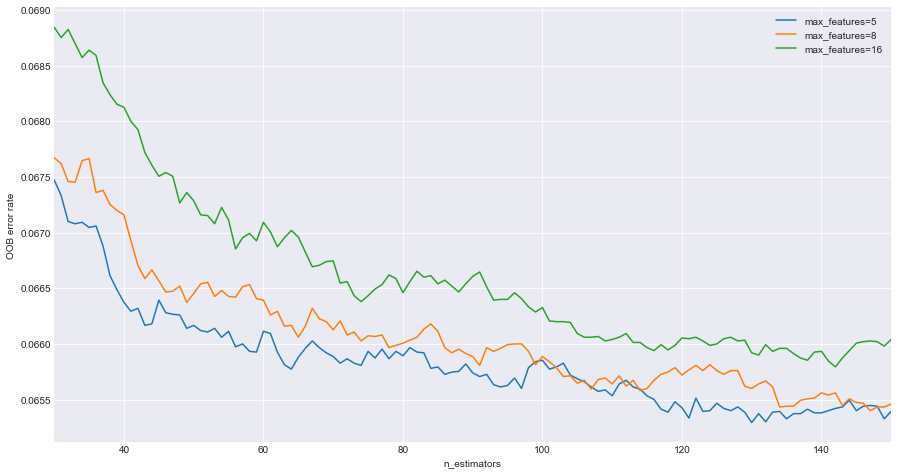

In [39]:
optimization_of_parameter_of_rf(train.iloc[:,1:].values, train.SeriousDlqin2yrs.values,{},'max_features',[5,8,16],30,150)


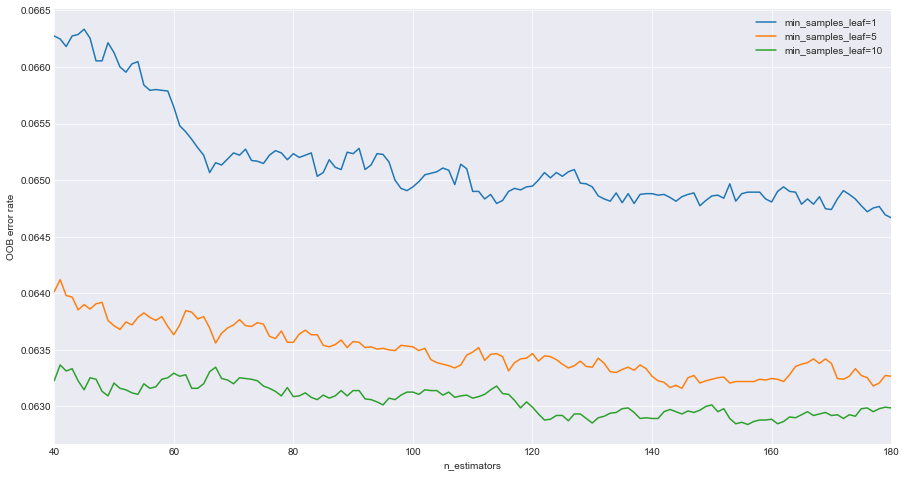

In [41]:
optimization_of_parameter_of_rf(train.iloc[:,1:].values, train.SeriousDlqin2yrs.values,{'max_features':5},'min_samples_leaf',[1,5,10],40,180)


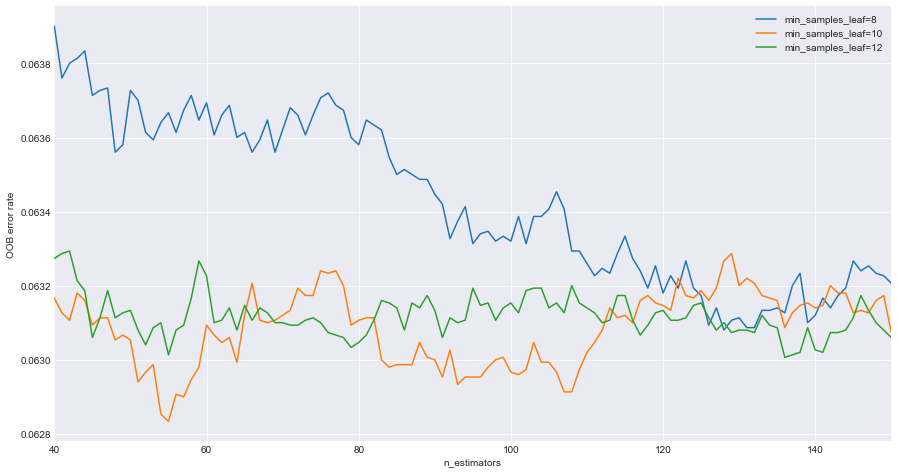

In [42]:
optimization_of_parameter_of_rf(train.iloc[:,1:].values, train.SeriousDlqin2yrs.values,{'max_features':5},'min_samples_leaf',[8,10,12],40,150)


In [64]:
rfc=RandomForestClassifier(n_estimators=300,max_features=5,min_samples_leaf=10)

rfc.fit(train.iloc[:,1:].values, train.SeriousDlqin2yrs.values)

preds=rfc.predict_proba(test.iloc[:,1:])
preds_df=pd.DataFrame({'Probability':preds[:,1]},index=range(1,101504))
preds_df.index.name='Id'
preds_df.to_csv('predictions1.csv')